In [1]:
import os
import sys

# Что бы стали доступны модули из ./scripts
sys.path.insert(0, os.path.abspath("../scripts"))

In [2]:
import pickle

import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


from tube.tools.cleaner import Cleaner
from tube.tools import dataset
from tube.tools.functions import timeseries_train_test_split, plotModelResults, plotCoefficients

In [3]:
DATA = "/home/ilya/iWorkspace/research/sibur-2020/data/tube"

train_features = os.path.join(DATA, "dataset", "train_features.csv")
train_targets = os.path.join(DATA, "dataset", "train_targets.csv")

MODELS = "/home/ilya/iWorkspace/research/sibur-2020/data/tube/models"

In [4]:
df_X = pd.read_csv(train_features, index_col="timestamp", parse_dates=True)
df_X.index.freq = "0.5H"

df_Y = pd.read_csv(train_targets, index_col="timestamp", parse_dates=True)
df_Y.index.freq = "0.5H"

# Clear (research)

In [8]:
cleaner = Cleaner()

In [9]:
df_X = cleaner.clean(df_X)
df_Y = cleaner.clean(df_Y)

In [10]:
df_X.index

DatetimeIndex(['2020-01-01 04:30:00', '2020-01-01 05:00:00',
               '2020-01-01 05:30:00', '2020-01-01 06:00:00',
               '2020-01-01 06:30:00', '2020-01-01 07:00:00',
               '2020-01-01 07:30:00', '2020-01-01 08:00:00',
               '2020-01-01 08:30:00', '2020-01-01 09:00:00',
               ...
               '2020-04-30 19:00:00', '2020-04-30 19:30:00',
               '2020-04-30 20:00:00', '2020-04-30 20:30:00',
               '2020-04-30 21:00:00', '2020-04-30 21:30:00',
               '2020-04-30 22:00:00', '2020-04-30 22:30:00',
               '2020-04-30 23:00:00', '2020-04-30 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=5799, freq='30T')

In [11]:
df_Y.index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:30:00',
               '2020-01-01 01:00:00', '2020-01-01 01:30:00',
               '2020-01-01 02:00:00', '2020-01-01 02:30:00',
               '2020-01-01 03:00:00', '2020-01-01 03:30:00',
               '2020-01-01 04:00:00', '2020-01-01 04:30:00',
               ...
               '2020-04-30 19:00:00', '2020-04-30 19:30:00',
               '2020-04-30 20:00:00', '2020-04-30 20:30:00',
               '2020-04-30 21:00:00', '2020-04-30 21:30:00',
               '2020-04-30 22:00:00', '2020-04-30 22:30:00',
               '2020-04-30 23:00:00', '2020-04-30 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=5808, freq='30T')

In [12]:
df_Y = df_Y['2020-01-01 04:30:00':]

In [13]:
start_trash = df_X.index.get_loc('2020-01-24').start
end_trash = df_X.index.get_loc('2020-02-13').start

df_X = df_X.drop( df_X.index[ start_trash:end_trash ] )
df_Y = df_Y.drop( df_Y.index[ start_trash:end_trash ] )

In [14]:
start_trash = df_X.index.get_loc('2020-04-08').start
end_trash = df_X.index.get_loc('2020-04-12').start

df_X = df_X.drop( df_X.index[ start_trash:end_trash ] )
df_Y = df_Y.drop( df_Y.index[ start_trash:end_trash ] )

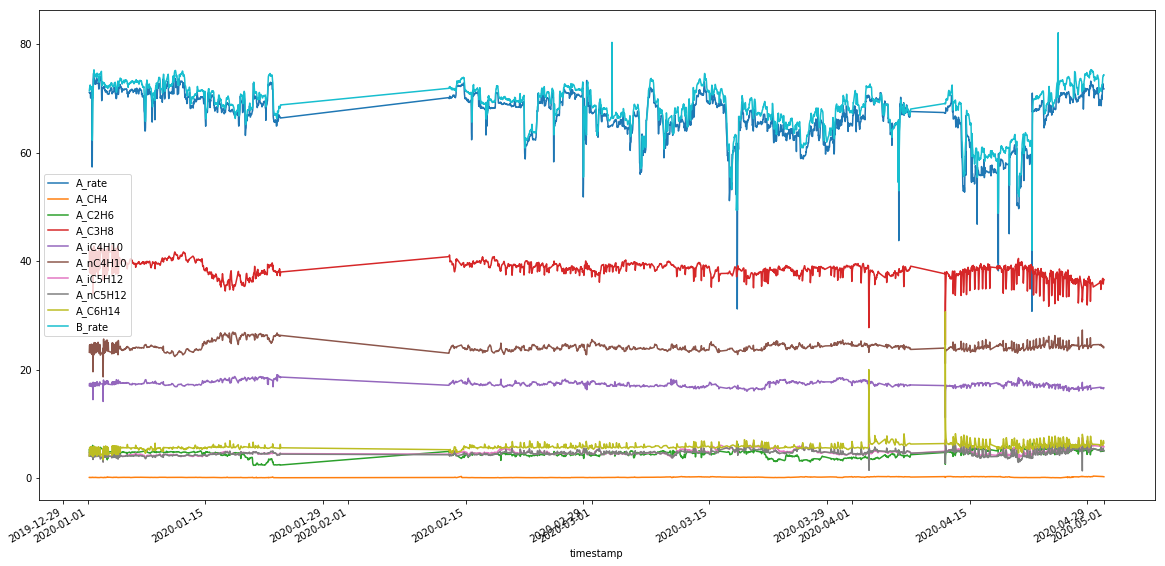

In [15]:
df_X.plot(figsize=(20,10))

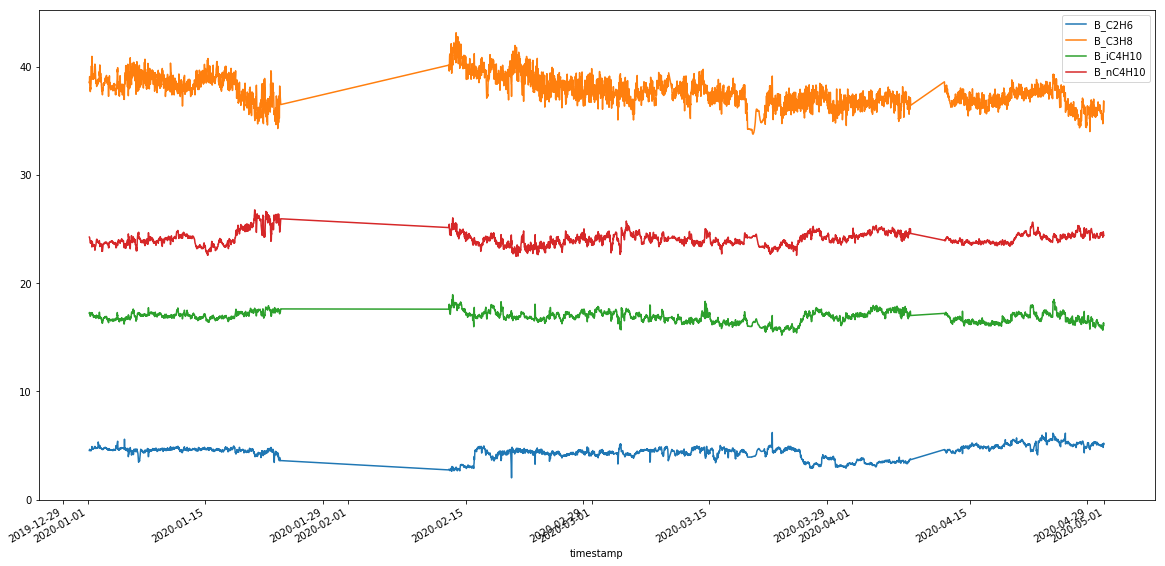

In [17]:
df_Y.plot(figsize=(20,10))

# Clear

In [5]:
df_X, df_Y = dataset.clear_train_dataset(df_X, df_Y)

 ## iC4H10

In [6]:
name = "iC4H10"

In [7]:
ds = dataset.prepare_dataset(name, df_X.shift(5), df_Y)

In [8]:
A_val = "A_{0}".format(name)
B_val = "B_{0}".format(name)

for column in [A_val]:
    for i in range(1, 300):
        ds[ "{0}-{1}".format(column, i) ] = ds[ column ].shift(i)
        ds[ "{0}+{1}".format(column, i) ] = ds[ column ].shift(-i)

In [9]:
y = ds.dropna()[B_val]
X = ds.dropna().drop([B_val, "A_rate", "B_rate"], axis=1)
#X = ds.dropna().drop([B_val], axis=1)

In [10]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

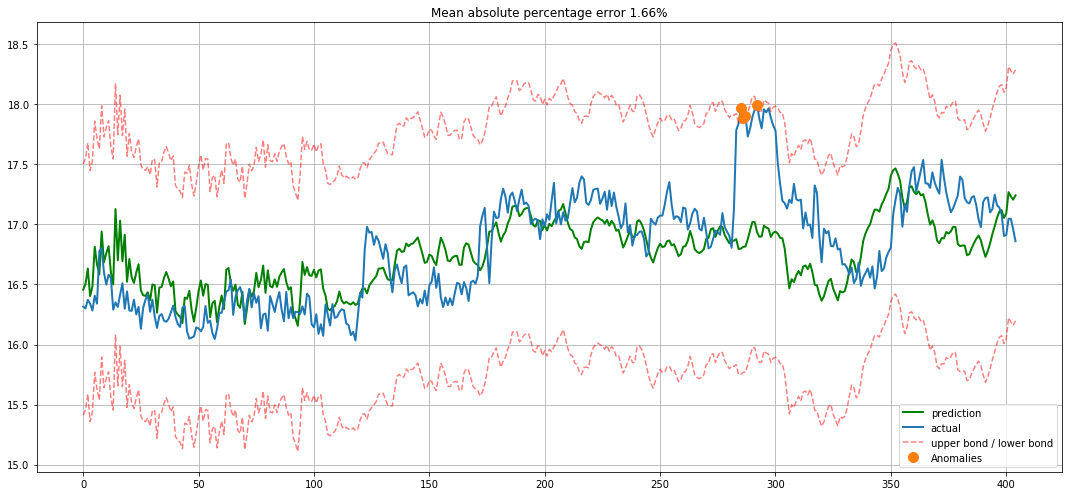

In [11]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr,
    X_train=X_train_scaled, X_test=X_test_scaled,
    y_train=y_train, y_test=y_test,
    plot_intervals=True, plot_anomalies=True)
#plotCoefficients(lr, y_train)

In [12]:
# =====================================
# SAVE iC4H10
# =====================================
fpath = os.path.join(MODELS, name + ".lr")
with open(fpath, 'wb') as fp:
    pickle.dump(lr, fp)

# C2H6

In [13]:
name = "C2H6"

In [14]:
ds = dataset.prepare_dataset(name, df_X.shift(10), df_Y)

In [15]:
A_val = "A_{0}".format(name)
B_val = "B_{0}".format(name)

#datasets[ name ] = datasets[ name ].shift(195).dropna()

for column in [A_val]:
    for i in range(170, 300):
        ds[ "{0}-{1}".format(column, i) ] = ds[ column ].shift(i)
        ds[ "{0}+{1}".format(column, i) ] = ds[ column ].shift(-i)

In [16]:
y = ds.dropna()[B_val]
X = ds.dropna().drop([B_val], axis=1)#drop([B_val, "A_rate", "B_rate"], axis=1)

In [17]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X.dropna(), y, test_size=0.1)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

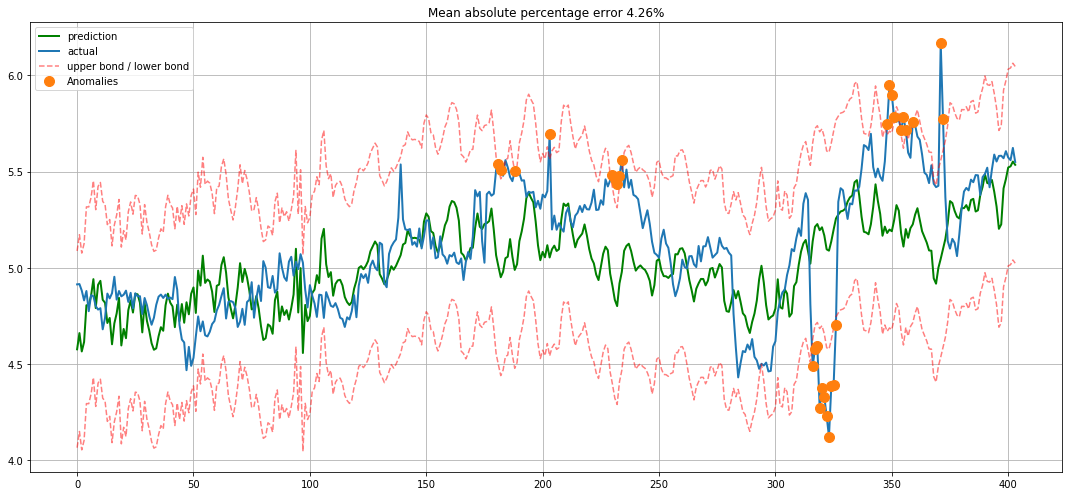

In [18]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr,
    X_train=X_train_scaled, X_test=X_test_scaled,
    y_train=y_train, y_test=y_test,
    plot_intervals=True, plot_anomalies=True)
#plotCoefficients(lr, y_train)

In [19]:
# =====================================
# SAVE C2H6
# =====================================
fpath = os.path.join(MODELS, name + ".lr")
with open(fpath, 'wb') as fp:
    pickle.dump(lr, fp)

# C3H8

In [20]:
name = "C3H8"

In [21]:
ds = dataset.prepare_dataset(name, df_X.shift(55), df_Y)

In [22]:
A_val = "A_{0}".format(name)
B_val = "B_{0}".format(name)

for column in [A_val]:
    for i in range(45, 100):
        ds[ "{0}-{1}".format(column, i) ] = ds[ column ].shift(i)
        #datasets[ name ][ "{0}+{1}".format(column, i) ] = datasets[ name ][ column ].shift(-i)

In [23]:
y = ds.dropna()[B_val]
X = ds.dropna().drop([B_val, "A_rate", "B_rate"], axis=1)

In [24]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

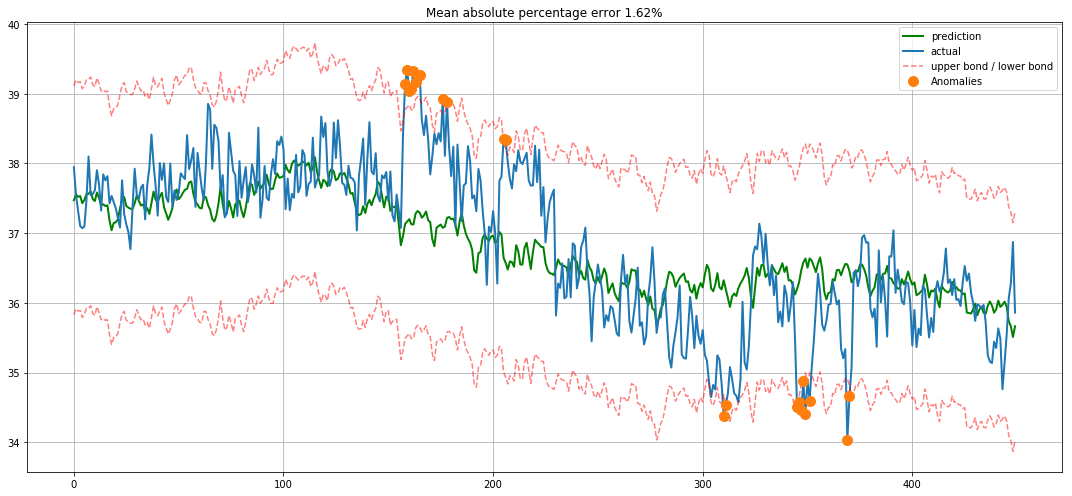

In [25]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr,
    X_train=X_train_scaled, X_test=X_test_scaled,
    y_train=y_train, y_test=y_test,
    plot_intervals=True, plot_anomalies=True)
#plotCoefficients(lr, y_train)

In [26]:
# =====================================
# SAVE C3H8
# =====================================
fpath = os.path.join(MODELS, name + ".lr")
with open(fpath, 'wb') as fp:
    pickle.dump(lr, fp)

## nC4H10

In [27]:
name = "nC4H10"

In [28]:
ds = dataset.prepare_dataset(name, df_X, df_Y)

In [29]:
A_val = "A_{0}".format(name)
B_val = "B_{0}".format(name)

for column in [A_val]:
    for i in range(1, 350):
        ds[ "{0}-{1}".format(column, i) ] = ds[ column ].shift(i)
        ds[ "{0}+{1}".format(column, i) ] = ds[ column ].shift(-i)
    
    #datasets[ name ][ "diff_1" ] = datasets[ name ][ column ] - datasets[ name ][ column ].shift(i)

In [30]:
y = ds.dropna()[B_val]
X = ds.dropna().drop([B_val, "A_rate", "B_rate"], axis=1)

In [31]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

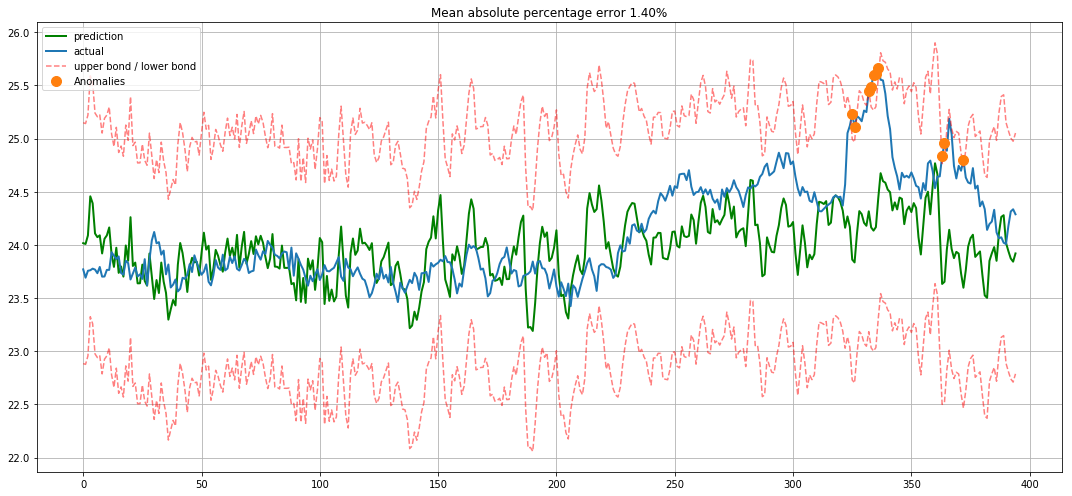

In [32]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr,
    X_train=X_train_scaled, X_test=X_test_scaled,
    y_train=y_train, y_test=y_test,
    plot_intervals=True, plot_anomalies=True)
#plotCoefficients(lr, y_train)

In [33]:
# =====================================
# SAVE nC4H10
# =====================================
fpath = os.path.join(MODELS, name + ".lr")
with open(fpath, 'wb') as fp:
    pickle.dump(lr, fp)